In [4]:
s = "https://mybucket.s3.amazonaws.com/"
import re
re.search(r'//(.+?)\.s3', s).groups(0)

('mybucket',)

# Gridding a bunch of x, y points

Often in earth science we'd like to represent some spatial data with a sampled, discretized, regular grid. You might call this a **raster**, a **surface**, a **horizon**, or just a **grid**. Or something else. Here's a very small one:

    3   4   7   9
    2   3   7   8
    1   3       8
    0   2   5   8
    
You can think of this as a map of heights (or depths, or temperatures, or anything). It has one missing value; we'll get to that.

Notice that there are no coordinates as such, just implicit 'row' and 'column' coordinates. So the value 4 is at (0, 1) for example, and the 5 is at (3, 2). That might seem a bit backwards: we'd normally give the 'x' coordinate first, then the 'y', but this is how matrices are indexed. People conventionally call these row, column indices i and j respectively. They will look like this:

       j  0   1   2   3

    i  0  3   4   7   9
       1  2   3   7   8
       2  1   3 NaN   8
       3  0   2   5   8

We can represent a grid like this as a `numpy` array. Notice that we don't need to have every sample &mdash; one or more might be missing. In their place, we'd have NaNs, not-a-numbers, which are null values that won't be plotted and will generally be ignored.

## Adding real-world coordinates

Very often, we'd like to refer to positions on the grid with real-world coordinates of some kind. For example, if this grid is a map, I might have UTMx and UTMy coordinates. Or, if this it's a seismic horizon, I might have inline and crossline numbers as well as UTMx and UTMy. In that case, `xarray` is useful because I can label the rows and columns with these real-world coordinates:

         100 101 102 103
         
    306   3   4   7   9
    304   2   3   7   8
    302   1   3 NaN   8
    300   0   2   5   8

Notice that the numbering of the vertical axis is opposite what we used for j, they don't start at 0 or 1, and they increment in steps of 2. That all just depends on how the real-world coordinates were assigned. They are arbitrary.

The data is the same, but now I can index into this grid using my real-world coordinates, which is much more convenient than having to know the (i, j) indices. But that's far from being the only useful thing about `xarray`. For example, imagine a text representation of this array. It might look something like this:

    iline,xline,z
    306,100,3
    306,101,4
    306,102,7
    306,103,9
    304,100,2
    304,101,3
    304,102,7
    304,103,8
    302,100,1
    302,101,3
    302,103,8
    300,100,0
    300,101,2
    300,102,5
    300,103,8
    
Notice that one position, (302, 102) is missing: that's the NaN. This is a bit of a headache to load into NumPy, because I can't just read the data elements and reshape &mdash; plus I have to throw away the coordinates. But with `xarray`, I can do this:

In [34]:
from bruges.transform import CoordTransform

corner_ix = [[0,  0], [0, 3], [3, 0]]
corner_xy = [[5000, 6000],
                 [5000-23.176, 6000+71.329],
                 [5000+142.658, 6000+46.353]]
transform = CoordTransform(corner_ix, corner_xy)

for i in range(4):
    for j in range(4):
        print(transform([i, j]))

[5000. 6000.]
[4992.27466667 6023.77633333]
[4984.54933333 6047.55266667]
[4976.824 6071.329]
[5047.55266667 6015.451     ]
[5039.82733333 6039.22733333]
[5032.102      6063.00366667]
[5024.37666667 6086.78      ]
[5095.10533333 6030.902     ]
[5087.38       6054.67833333]
[5079.65466667 6078.45466667]
[5071.92933333 6102.231     ]
[5142.658 6046.353]
[5134.93266667 6070.12933333]
[5127.20733333 6093.90566667]
[5119.482 6117.682]


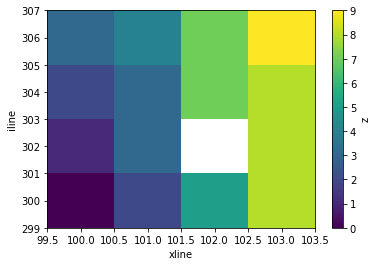

In [14]:
import pandas as pd
import xarray as xr

df = pd.read_csv('data.csv')
df = df.set_index(['iline', 'xline'])
da = xr.DataArray.from_series(df.z)
da.plot()

## Adding (x, y) coordinates

Often I have UTMx and UTMy coordinates for the map &mdash; maybe just for one or more of its corner points, or maybe for every cell. If I have 3 corners, I can compute the (x, y) location of every cell, assuming the cell spacing is regular. If I have fewer than 3 corners, I will need to know the cell spacing in both directions, and the angle of one of the axes with respect to north.

I can attach (x, y) coordinates to the `xarray`, but there's a catch. Unless the grid is exactly aligned with north, I will need an (x, y) pair at _every_ cell, because the rows won't line up (i.e. the x-coordinates of the second row cells will be different from the x-coordinates of the first row cells). No problem, [`xarray` can handle this](https://xarray.pydata.org/en/stable/examples/multidimensional-coords.html).

In [34]:
from bruges.transform import CoordTransform

corner_ix = [[0,  0], [0, 3], [3, 0]]
corner_xy = [[5000, 6000],
                 [5000-23.176, 6000+71.329],
                 [5000+142.658, 6000+46.353]]
transform = CoordTransform(corner_ix, corner_xy)

for i in range(4):
    for j in range(4):
        print(transform([i, j]))

[5000. 6000.]
[4992.27466667 6023.77633333]
[4984.54933333 6047.55266667]
[4976.824 6071.329]
[5047.55266667 6015.451     ]
[5039.82733333 6039.22733333]
[5032.102      6063.00366667]
[5024.37666667 6086.78      ]
[5095.10533333 6030.902     ]
[5087.38       6054.67833333]
[5079.65466667 6078.45466667]
[5071.92933333 6102.231     ]
[5142.658 6046.353]
[5134.93266667 6070.12933333]
[5127.20733333 6093.90566667]
[5119.482 6117.682]


In [31]:
arr

array([[0, 1],
       [0, 1],
       [0, 2],
       [0, 3]])

## Constructing the grid from data

We often have a bunch of arbitary points with (x, y) coordinates (e.g. UTMx and UTMy, or longitude and latitude) and interpolate them to end up with a